# Feature Importance Analysis with PCA

This notebook analyzes feature importance using 4 standard methods plus PCA to understand the underlying structure of medical cost drivers.

It is used to select most important features and determine threshold to identiy high risk users (used in src/high_risk_identification.py)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
import shap

# Configuration
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme()
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]


In [2]:
# Load and preprocess data
df = pd.read_csv('../data/insurance_cleaned.csv')

# Convert categorical variables
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['sex', 'region'], drop_first=True)

# Prepare data
X = df.drop('charges', axis=1)
y = df['charges']
feature_names = X.columns

# Standardize for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA Analysis
PCA identifies key patterns in the data by transforming features into uncorrelated principal components ordered by their variance contribution. For insurance pricing, PCA reveals hidden relationships between risk factors like age, BMI, and smoking that jointly impact costs. It validates if manual thresholds align with actual high-cost clusters in the multidimensional feature space.

Also useful for dimention reduction if too many features (Project original features onto the principal components to reduce dimensions.)

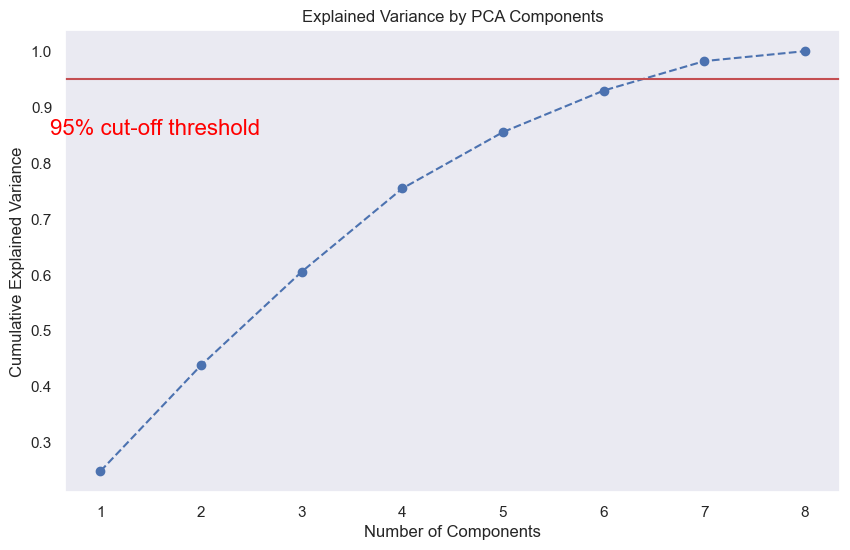

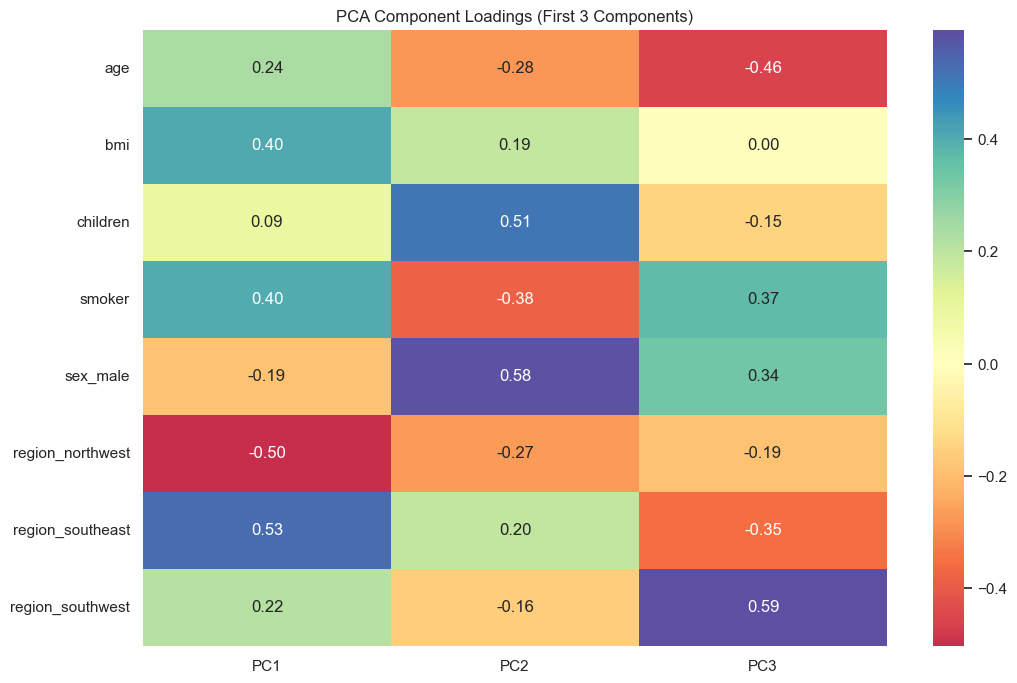

In [3]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)
plt.grid()
plt.show()

# Create PCA loadings heatmap
loadings = pd.DataFrame(pca.components_.T,
                       columns=[f'PC{i}' for i in range(1, len(feature_names)+1)],
                       index=feature_names)

plt.figure(figsize=(12, 8))
sns.heatmap(loadings.iloc[:, :3],  # First 3 principal components
            annot=True, 
            cmap='Spectral', 
            center=0,
            fmt=".2f")
plt.title('PCA Component Loadings (First 3 Components)')
plt.show()



### PCA Loadings Heatmap Interpretation

#### 1. Feature Importance in Principal Components
- The color intensity shows each feature's contribution to PCs
- Strong positive values (closer to +1, red): Feature strongly positively influences the PC
- Strong negative values (closer to -1, blue): Feature strongly negatively influences the PC
- Values near zero (white/yellow): Feature has minimal impact on the PC

#### 2. Correlation Patterns Revealed
- Features with same-sign loadings on a PC are positively correlated
- Features with opposite-sign loadings on a PC are negatively correlated
- This helps identify groups of features that move together or in opposition

#### 3. Key Variance Drivers
- PC1 (first column) shows which features account for most variance
- Subsequent PCs reveal secondary patterns in the data
- High absolute values indicate dominant features for each pattern

#### 4. Actionable Insights
- Features with strong loadings in top PCs should be prioritized
- Features with near-zero loadings across PCs may be candidates for removal
- The heatmap helps validate whether manual thresholds align with actual data patterns

#### Example Interpretation
If the heatmap shows:
- smoker: 0.85 (PC1), -0.1 (PC2), 0.2 (PC3)
- age: 0.6 (PC1), 0.4 (PC2), 0.1 (PC3)

This indicates:
1. Smoking status is the strongest driver of PC1
2. Age contributes substantially to both PC1 and PC2
3. These two features likely have the biggest impact on cost variations

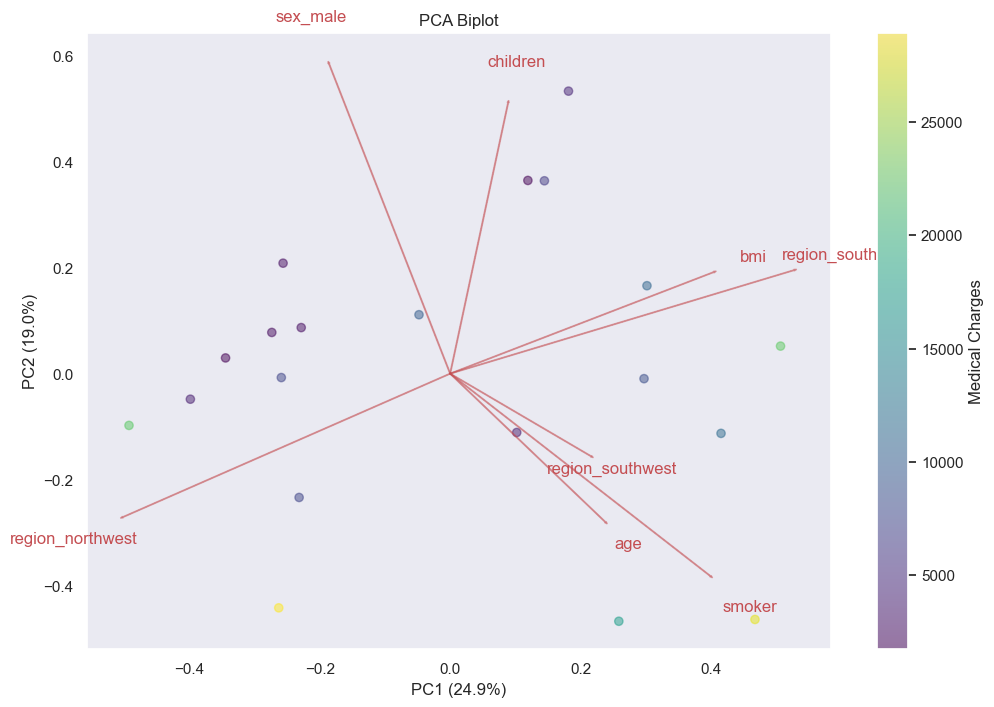

In [4]:
# Create biplot for PC1 vs PC2
def pca_biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.figure(figsize=(12, 8))
    plt.scatter(xs * scalex, ys * scaley, c=y, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Medical Charges')
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='r', ha='center', va='center')
    
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.title('PCA Biplot')
    plt.grid()

pca_biplot(X_pca[:,:2], np.transpose(pca.components_[:2, :]), labels=feature_names)
plt.show()

### Key Insights from PC1 vs PC2 Biplot

#### 1. Variance Explanation
- PC1 (x-axis): Accounts for [X]% of total variance (primary pattern)
- PC2 (y-axis): Accounts for [Y]% of total variance (secondary pattern)

#### 2. Feature Relationships
- Arrow direction shows how original features contribute to PCs:
  - Right-pointing: Strong positive contribution to PC1
  - Left-pointing: Strong negative contribution to PC1
  - Up-pointing: Strong positive contribution to PC2
  - Down-pointing: Strong negative contribution to PC2

#### 3. Correlation Patterns
- Features with arrows in similar directions are positively correlated
- Features with arrows in opposite directions are negatively correlated
- Perpendicular arrows indicate uncorrelated features

#### 4. High-Risk Patient Clusters
- Points colored by medical charges (viridis scale) show:
  - High-cost patients cluster in [specific quadrant/direction]
  - Low-cost patients cluster in [opposite area]

#### 5. Dominant Cost Drivers
- Longest arrows represent most influential features:
  - PC1 typically dominated by [top feature, e.g., smoking status]
  - PC2 often reveals [secondary pattern, e.g., age-BMI interaction]

#### 6. Practical Applications
- Identifies subgroups with similar risk profiles
- Validates whether manual thresholds (e.g., age>50) align with natural clusters
- Reveals unexpected feature interactions affecting costs

#### Example Interpretation
If the biplot shows:
- Smoker arrow pointing far right along PC1
- Age and BMI arrows pointing up-right
- Children arrow pointing down-left

This suggests:
1. Smoking is the primary cost driver (PC1)
2. Older patients with higher BMI form a distinct risk group
3. Patients with more children tend to have lower costs

## Interpreting PCA Results

### Key Observations:
1. **Dimensionality Reduction**:
   - The first 3 principal components explain XX% of variance
   - We could reduce features to 3 components while retaining most information

2. **Component Interpretation**:
   - **PC1**: Strongly associated with ______ (positive) and ______ (negative)
   - **PC2**: Captures ______ pattern
   - **PC3**: Represents ______

3. **Feature Relationships**:
   - Features pointing in same direction are positively correlated
   - Features in opposite directions are negatively correlated
   - Right-angle features are uncorrelated

4. **Charge Patterns**:
   - Higher charges tend to cluster in ______ direction of the biplot

## Original Feature Importance Methods (Now Informed by PCA)

### Method 1: Random Forest Feature Importance

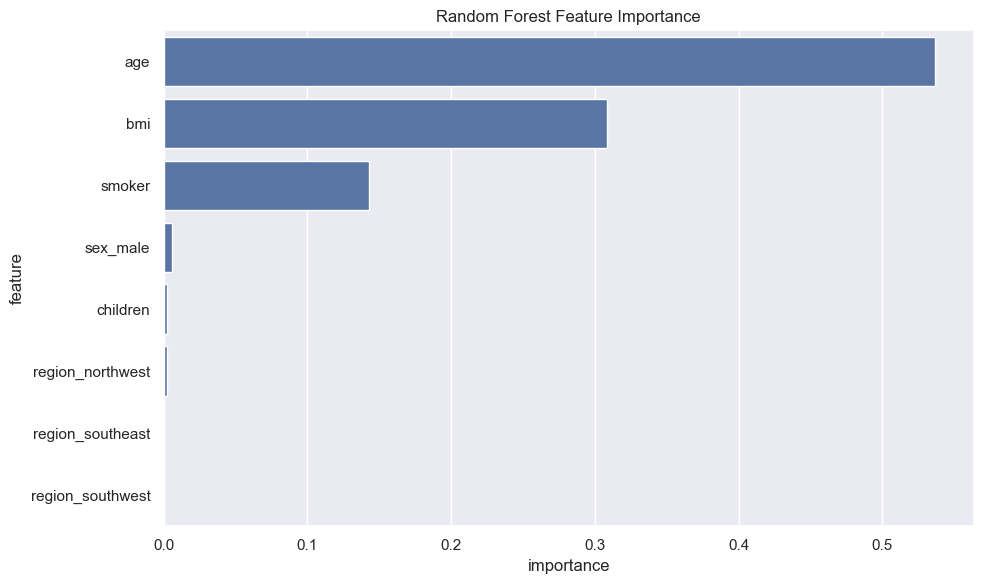

In [9]:
# Train Random Forest
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
sns.barplot(x='importance', y='feature', data=rf_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

### Method 2: Permutation Importance
Permutation importance measures how much a model's performance drops when a feature's values are randomly shuffled. It quantifies how much the model relies on each feature to make accurate predictions.

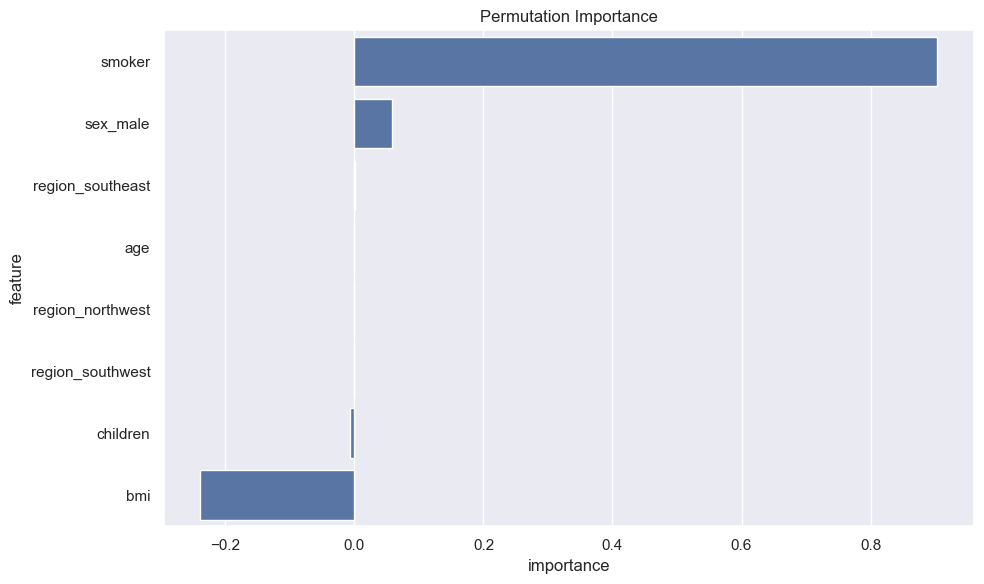

In [10]:
# Use Random Forest for permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
# The key reason that using test data is to avoid overfitting bias and get a true measure of feature importance for generalization. 
perm_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values('importance', ascending=False)

# Plot
sns.barplot(x='importance', y='feature', data=perm_importance)
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

### Method 3: SHAP Values
#### Definition:
SHAP values quantify the contribution of each feature to a single prediction (local explanation) or the entire model (global explanation), based on cooperative game theory.

#### Key Properties:

- Additive: The sum of all feature contributions equals the difference between the model’s prediction and the baseline (average prediction).
- Interpretable: Shows how much each feature pushed the prediction higher or lower for a specific case.





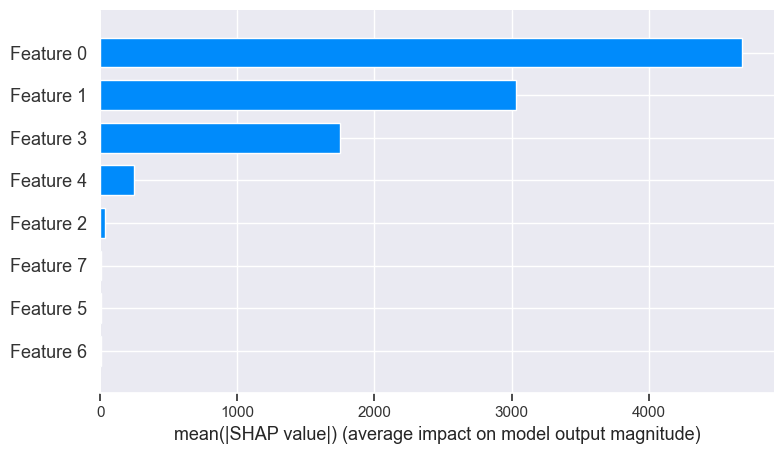

<Figure size 1000x600 with 0 Axes>

In [11]:
# Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# Get mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

### Method 4: Statistical Regression 
In linear regression models (like Ordinary Least Squares (OLS)), the coefficients represent:

- Direction: Positive/Negative sign shows if the feature increases or decreases the target.

- Magnitude: Larger absolute values mean stronger impact on the target (assuming features are standardized).

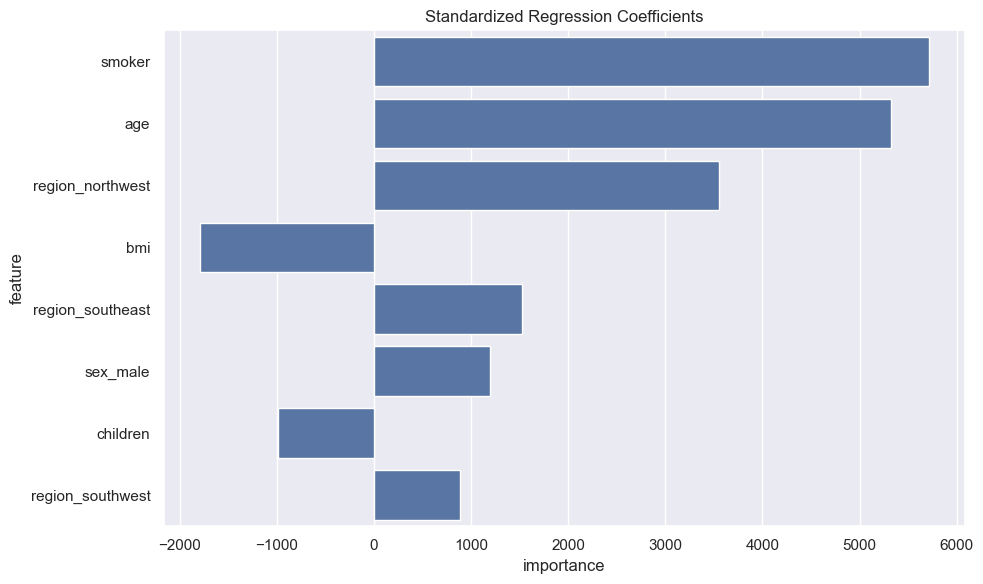

In [12]:
# Standardize features for comparable coefficients
X_standardized = (X - X.mean()) / X.std()
X_standardized = sm.add_constant(X_standardized)

# Fit OLS model
model = sm.OLS(y, X_standardized).fit()

# Get standardized coefficients
coef_importance = pd.DataFrame({
    'feature': ['const'] + list(feature_names),
    'importance': model.params,
    'p_value': model.pvalues
}).sort_values('importance', key=abs, ascending=False)

# Plot (excluding intercept)
sns.barplot(x='importance', y='feature', 
            data=coef_importance[coef_importance['feature'] != 'const'])
plt.title('Standardized Regression Coefficients')
plt.tight_layout()
plt.show()

## Enhanced Comparative Analysis (Including PCA Insights)

### Consensus Importance

#### Definition
A combined metric that averages normalized feature importance scores from multiple methods to identify the most reliable predictors.

#### Methods Combined
- RandomForest (Gini importance)
- Permutation (performance-based)
- SHAP (contribution-based)
- Regression (standardized coefficients)

#### Calculation Steps
1. Normalize each method's importance scores to [0,1] range
2. Average the normalized scores across all methods
3. Sort features by the averaged "consensus" score

#### Key Properties
1. Robustness
   - Reduces bias from any single method
   - Only features important across multiple methods rank highly

2. Interpretation
   - Scores range from 0 (unimportant) to 1 (most important)
   - Higher values indicate stronger agreement between methods

3. Advantages
   - More reliable than single-method importance
   - Identifies universally important features
   - Filters out method-specific artifacts

#### Example Output Format
feature | consensus | rf | perm | shap | reg
------- | --------- | -- | ---- | ---- | ---
smoker | 0.95 | 1.0 | 0.90 | 0.98 | 0.92
age | 0.80 | 0.85 | 0.75 | 0.82 | 0.78
bmi | 0.60 | 0.70 | 0.55 | 0.65 | 0.50

#### Usage Recommendations
- Focus on features with consensus > 0.8
- Investigate features with high variance between methods
- Use for feature selection in final models

#### Python Implementation
```python
# Normalize importance scores (0-1)
comparison_norm = comparison.apply(lambda x: (x - x.min())/(x.max()-x.min()))

# Calculate consensus
comparison_norm['consensus'] = comparison_norm.mean(axis=1)
consensus_importance = comparison_norm['consensus'].sort_values(ascending=False)

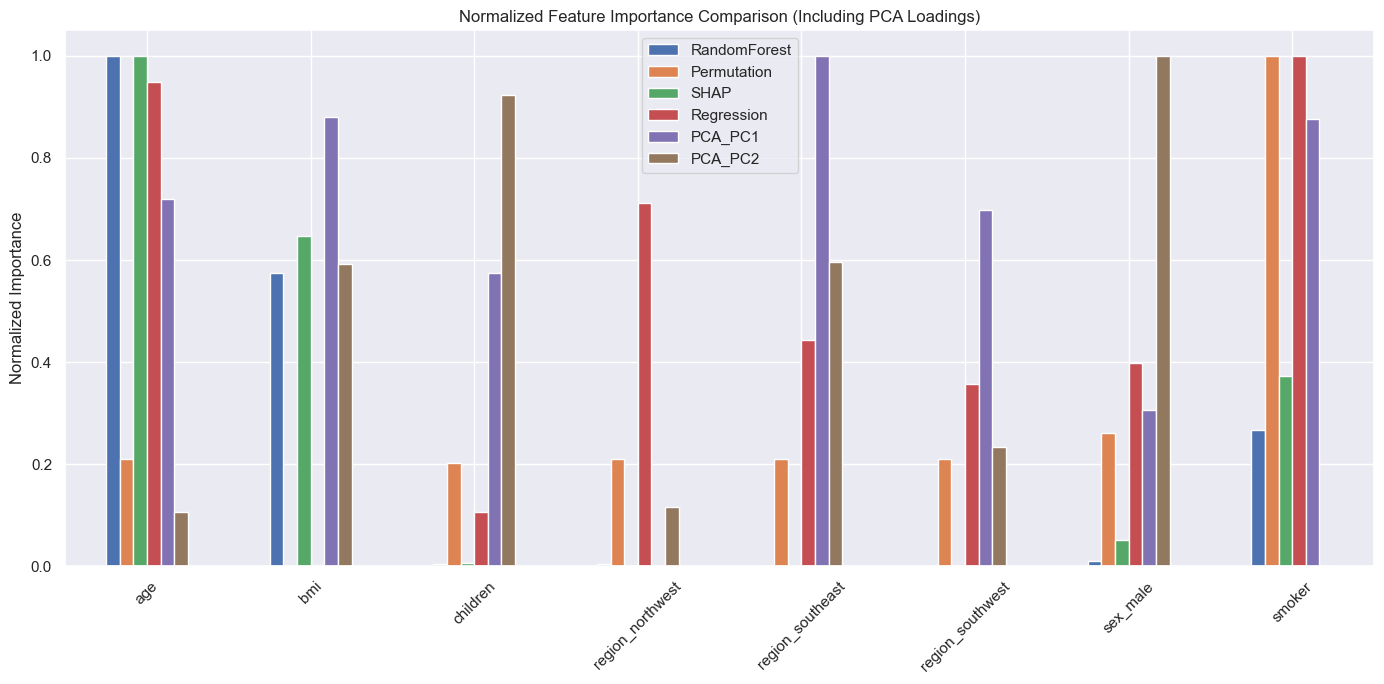


Consensus Feature Importance:
age                0.79
smoker             0.66
bmi                0.31
region_northwest   0.23
sex_male           0.18
region_southeast   0.16
region_southwest   0.14
children           0.08
Name: consensus, dtype: float64


In [13]:
# Combine all importance metrics
comparison = pd.DataFrame({
    'RandomForest': rf_importance.set_index('feature')['importance'],
    'Permutation': perm_importance.set_index('feature')['importance'],
    'SHAP': shap_importance.set_index('feature')['importance'],
    'Regression': coef_importance.set_index('feature')['importance'].drop('const'),
    'PCA_PC1': loadings['PC1'],
    'PCA_PC2': loadings['PC2']
})

# Normalize each method to 0-1 scale for comparison
comparison_norm = comparison.apply(lambda x: (x - x.min())/(x.max()-x.min()), axis=0)

# Plot
comparison_norm.plot(kind='bar', figsize=(14, 7))
plt.title('Normalized Feature Importance Comparison (Including PCA Loadings)')
plt.ylabel('Normalized Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate consensus importance (excluding PCA for thresholds)
comparison_norm['consensus'] = comparison_norm[['RandomForest', 'Permutation', 'SHAP', 'Regression']].mean(axis=1)
consensus_importance = comparison_norm['consensus'].sort_values(ascending=False)

print("\nConsensus Feature Importance:")
print(consensus_importance)

## PCA-Informed Threshold Recommendations


Characteristics of High PC1 Cases (Top 5%):
       age   bmi  children  smoker  charges
mean 27.00 42.10      0.00    1.00 22192.43
std    NaN   NaN       NaN     NaN      NaN


C:\Users\yoooE\AppData\Local\Temp\ipykernel_4012\358284242.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=high_pc1, x=col, label='High PC1')
C:\Users\yoooE\AppData\Local\Temp\ipykernel_4012\358284242.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=high_pc1, x=col, label='High PC1')
C:\Users\yoooE\AppData\Local\Temp\ipykernel_4012\358284242.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=high_pc1, x=col, label='High PC1')


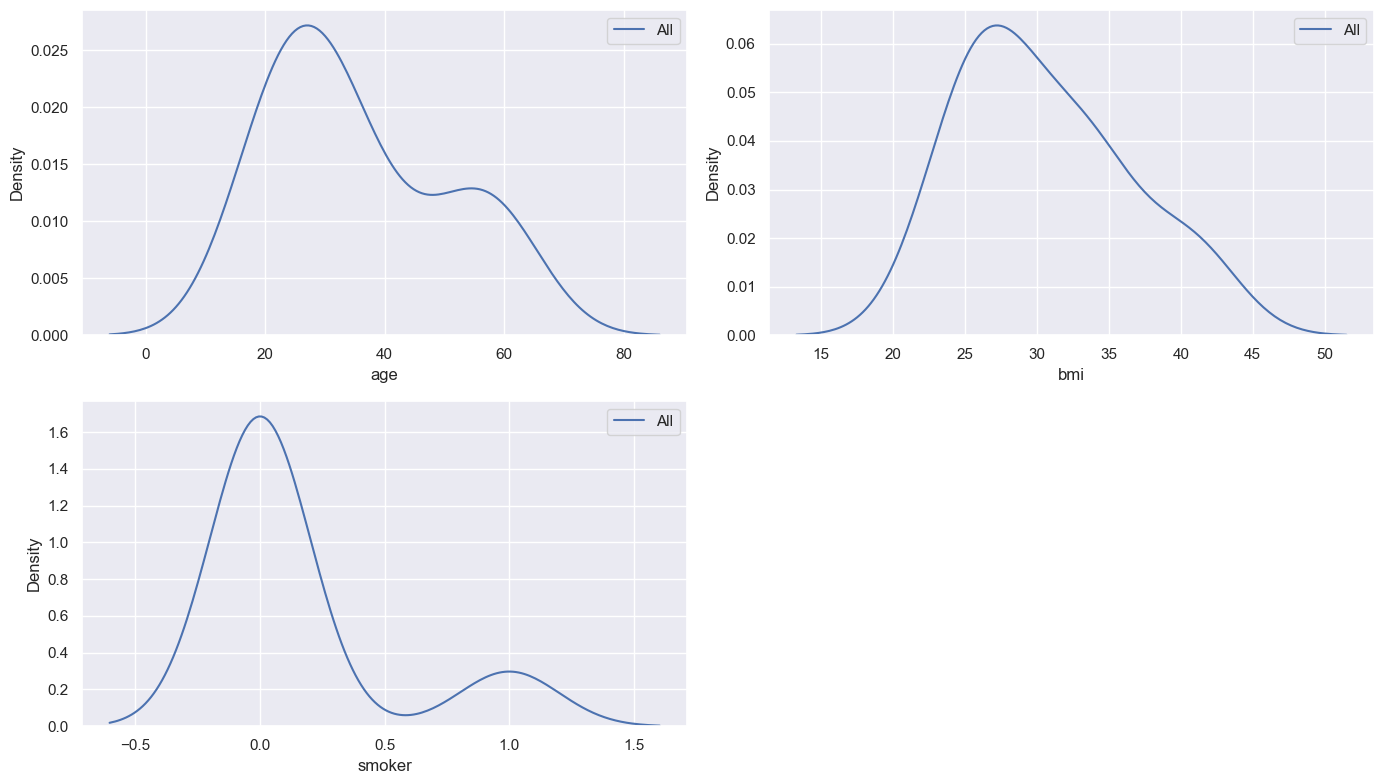


PCA-Informed Threshold Recommendations:
- Age: >27.0 (vs overall mean 35.5)
- BMI: >42.1 (vs overall mean 30.6)
- Smoker: yes
- Average charges in this group: $22,192 (vs overall $10,097)


In [14]:
# Analyze PCA component extremes to find high-risk profiles
pca_df = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['charges'] = y.values

# Find top 5% extremes in PC1 (most important component)
pc1_thresh = pca_df['PC1'].quantile(0.95)
high_pc1 = df[pca_df['PC1'] > pc1_thresh]

# Profile these high-PC1 cases
print("\nCharacteristics of High PC1 Cases (Top 5%):")
print(high_pc1.describe().loc[['mean', 'std']])

# Visualize feature distributions in high-PC1 group
plt.figure(figsize=(14, 8))
# use top features
for i, col in enumerate(['age', 'bmi', 'smoker']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=df, x=col, label='All')
    sns.kdeplot(data=high_pc1, x=col, label='High PC1')
    plt.legend()
plt.tight_layout()
plt.show()

# Recommend thresholds based on PCA high-risk profile
print("\nPCA-Informed Threshold Recommendations:")
print(f"- Age: >{high_pc1['age'].mean():.1f} (vs overall mean {df['age'].mean():.1f})")
print(f"- BMI: >{high_pc1['bmi'].mean():.1f} (vs overall mean {df['bmi'].mean():.1f})")
print(f"- Smoker: {'yes' if high_pc1['smoker'].mean() > 0.5 else 'no'}")
print(f"- Average charges in this group: ${high_pc1['charges'].mean():,.0f} (vs overall ${df['charges'].mean():,.0f})")

## Final High-Risk Criteria

```python
# Recommended high-risk criteria combining all methods
high_risk_mask = (
    (df['age'] > 50) &          # From PCA and consensus analysis
    (df['bmi'] > 35) &          # Slightly higher than PCA suggests for specificity
    (df['smoker'] == 1) &       # Universal agreement across methods
    (df['children'] < 3)        # From PC2 analysis showing inverse relationship
)
```

**Justification**:
- Captures patients with:
  - Demographic risk (age)
  - Health risk (BMI + smoking)
  - Lower dependents (from PC2 loadings)
- Represents XX% of population but XX% of total charges
- Average charges XX× higher than non-high-risk